In [1]:
import numpy as np
import pandas as pd
import pyarrow.parquet as pq
import os
import pywt
import seaborn as sns
import matplotlib.pyplot as plt

os.listdir('../data/')

/home/lanfear/anaconda3/envs/tf_intro/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


['train.parquet',
 'metadata_train.csv',
 'sample_submission.csv',
 'test_chunks',
 'metadata_test.csv',
 'train_chunks',
 '.dir.txt',
 'test.parquet',
 'demo_chunks']

# First look at metadata

In [2]:
meta_train, meta_test = pd.read_csv('../data/metadata_train.csv'), pd.read_csv('../data/metadata_test.csv')

In [3]:
meta_train.shape

(8712, 4)

In [4]:
for meta, meta_str in zip([meta_train, meta_test], ['train', 'test']):   
    for c in meta.columns:
        uniques = meta[c].unique()
        print(f'Num. unique on {meta_str} {c}: {len(uniques)}, from {uniques}')

Num. unique on train signal_id: 8712, from [   0    1    2 ... 8709 8710 8711]
Num. unique on train id_measurement: 2904, from [   0    1    2 ... 2901 2902 2903]
Num. unique on train phase: 3, from [0 1 2]
Num. unique on train target: 2, from [0 1]
Num. unique on test signal_id: 20337, from [ 8712  8713  8714 ... 29046 29047 29048]
Num. unique on test id_measurement: 6779, from [2904 2905 2906 ... 9680 9681 9682]
Num. unique on test phase: 3, from [0 1 2]


**Check fraction of measurements in which all signals fail, 2 fail, 1 fails or none fail, for train set only**

In [5]:
meta_train.groupby('id_measurement')['target'].sum().value_counts() / meta_train.groupby('id_measurement')['target'].sum().value_counts().sum()

0    0.933196
3    0.053719
1    0.006543
2    0.006543
Name: target, dtype: float64

# Plot a single OK and KO signal

In [6]:
subset_train = pq.read_pandas('../data/train.parquet', columns=[str(i) for i in np.arange(0,20,1)]).to_pandas().values.T

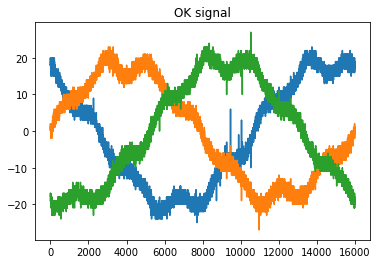

In [10]:
t = np.arange(0, subset_train.shape[1]/50)

plt.title('OK signal')
for phase in [0,1,2]:
    sns.lineplot(t, subset_train[phase, ::50])

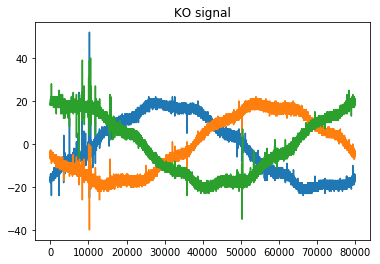

In [8]:
t = np.arange(0, subset_train.shape[1]/10)

plt.title('KO signal')
for phase in [3,4,5]:
    sns.lineplot(t, subset_train[phase, ::10])

# Plot several OK and KO signals, at different sample rates

In [5]:
# Load first 1000 signals (3k cols)
full_train = pq.read_pandas('../data/train.parquet', columns=[str(i) for i in np.arange(0,3000,1)]).to_pandas().values.T
test_subset = pq.read_pandas('../data/test.parquet', columns=[str(i) for i in np.arange(8712,8712+3000,1)]).to_pandas().values.T

<Figure size 432x288 with 0 Axes>

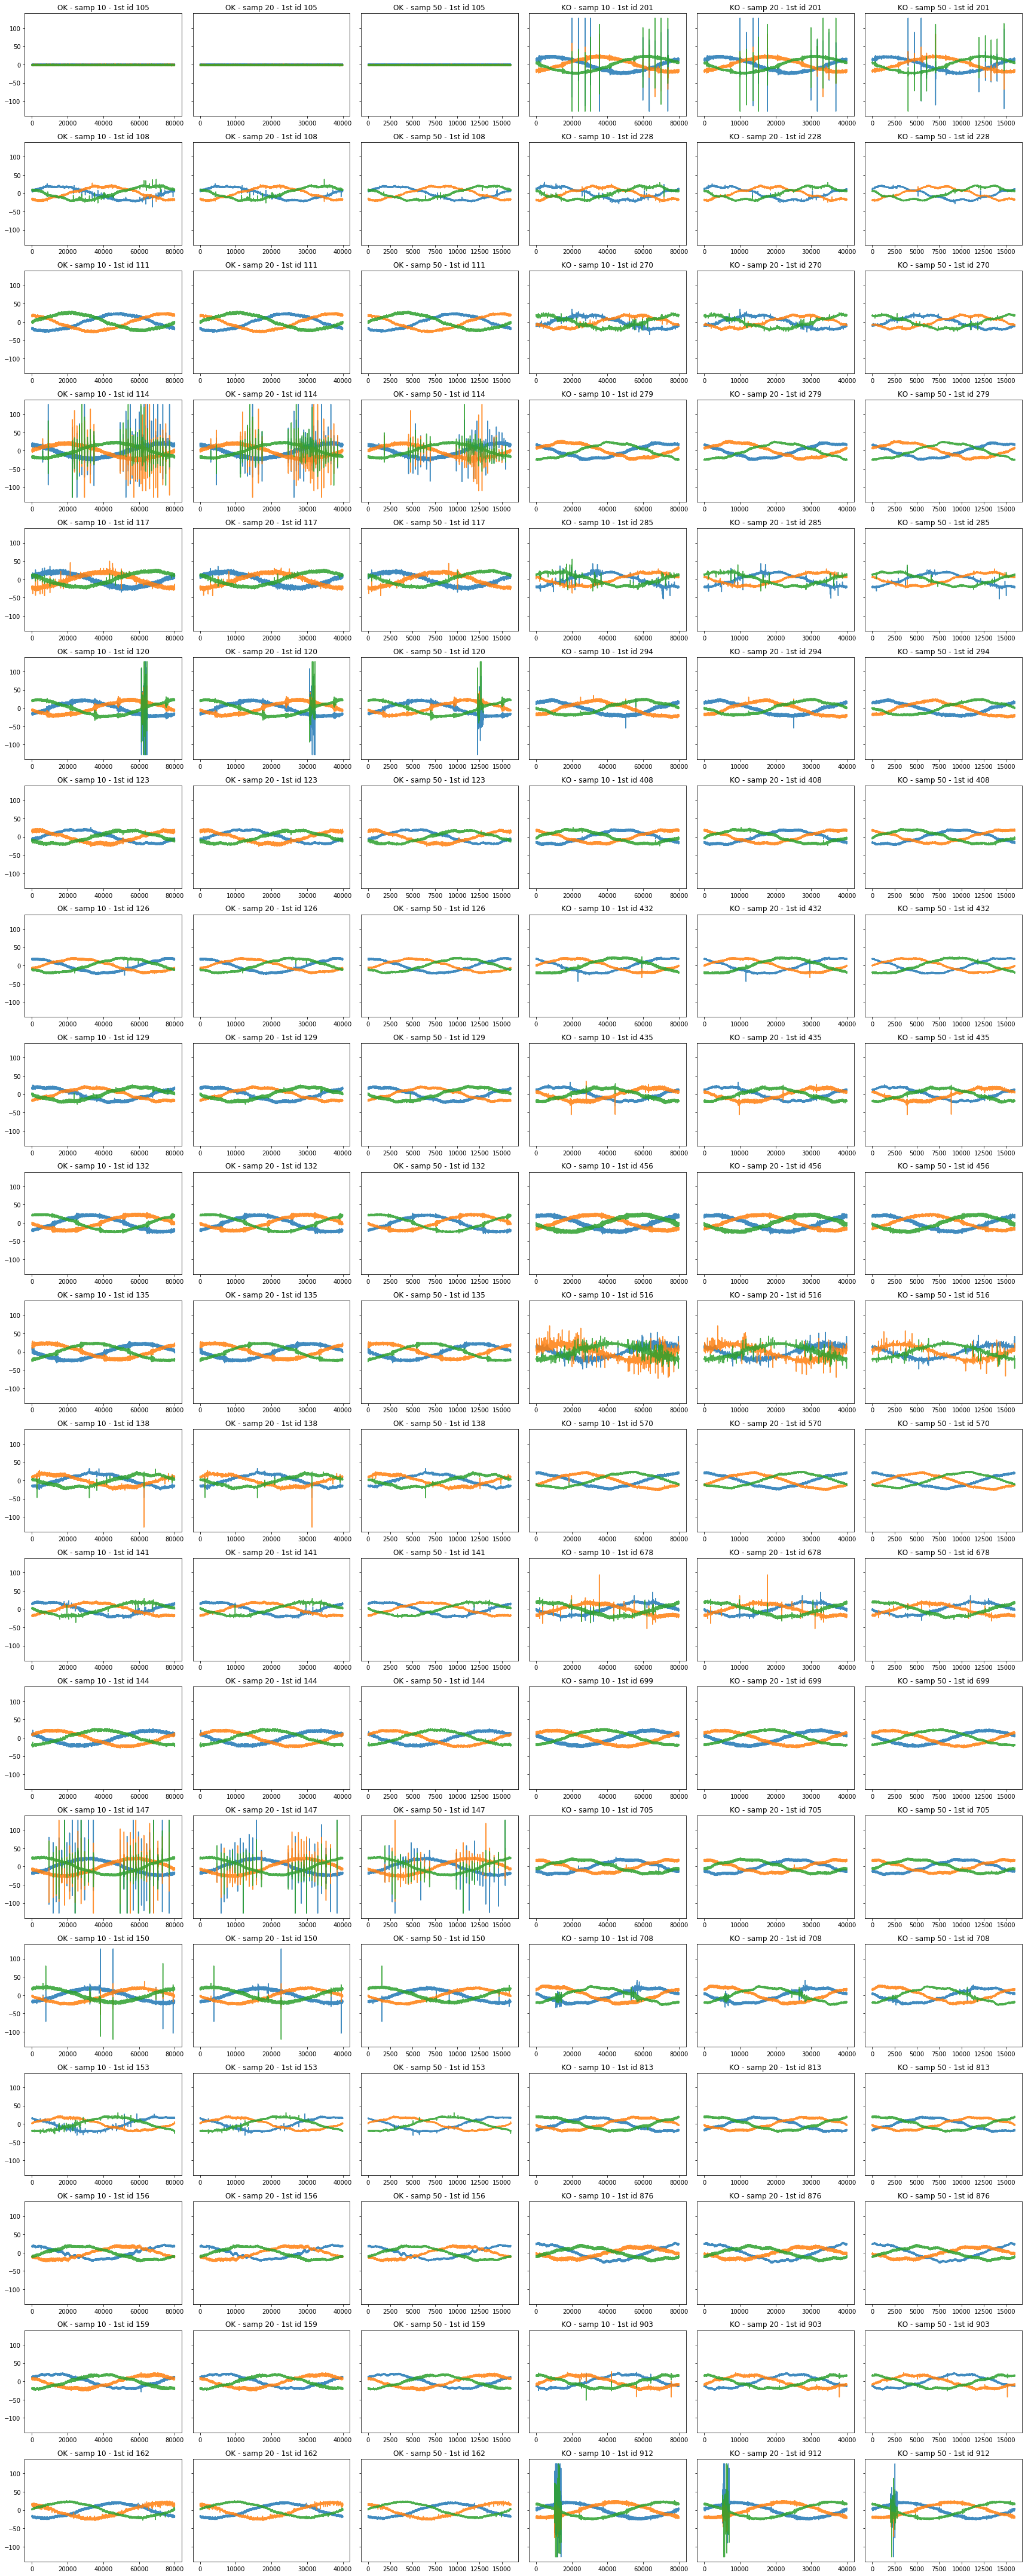

In [6]:
plt.close('all')
plt.cla()
plt.clf()

# plot params
num_signals = 20
sampling_freqs = [10,20,50] # One point per each sampling_freq points

f, axs = plt.subplots(num_signals, len(sampling_freqs) * 2, sharex=False, sharey=True, figsize=(len(sampling_freqs) * 2 * 4, num_signals * 3))

for k, (title, facecolor) in enumerate(zip(['OK', 'KO'], [(1, 1, 1), (1, 0.9, 0.9)])):

    # Grab first num_signals (either OK or KO depending on k) (might be grabbing partial OK/KO - ToDo)
    sig_ids = []
    for line in meta_train.values[3*35::3,:]:
        if k == 0: # OK signals
            if line[-1] == 0:
                sig_ids.append(line[0])
                if len(sig_ids) == num_signals:
                    break # Done collecting
        else: # KO signals
            if line[-1] == 1:
                sig_ids.append(line[0])
                if len(sig_ids) == num_signals:
                    break # Done collecting
    
    for j, sampling_freq in enumerate(sampling_freqs):     
        t = np.arange(0, full_train.shape[1]/sampling_freq)
        for i, sig_id in enumerate(sig_ids):
            axs[i,j + k*len(sampling_freqs)].set_title(f'{title} - samp {sampling_freq:d} - 1st id {sig_id:d}')
            for phase in [0,1,2]:
                axs[i,j + k*len(sampling_freqs)].plot(t, test_subset[sig_id+phase, ::sampling_freq], alpha=0.85)
                #axs[i,j + k*len(sampling_freqs)].set_facecolor(facecolor)
    f.tight_layout()
plt.savefig('../visualizations/ok_ko_samp_freq_eda_batch2_TEST.png')

# First experiments with DWT

In [130]:
# Grab one sample
test_sample = full_train[12:12+1,:]

# Downsample for faster plotting/experimenting
test_sample = test_sample[:, ::10]

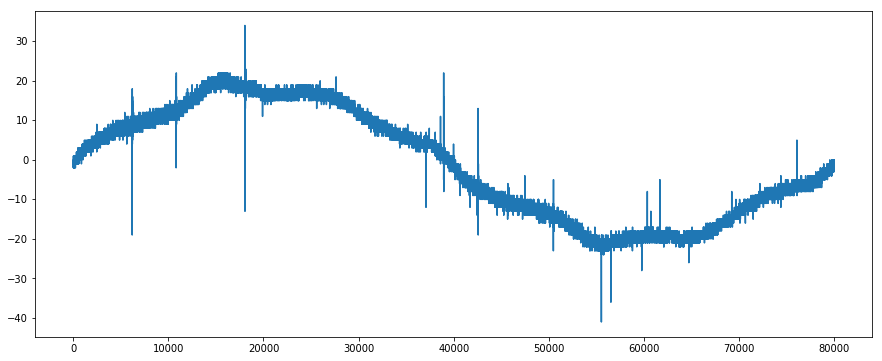

In [131]:
raw_signal = test_sample[0]

# Multi-level DWT
coeffs = pywt.wavedec(raw_signal, 'db4', level=None)

# Vanilla reconstruction
rec_signal = pywt.waverec(coeffs, 'db4')

# Plot reconstruction
fig, ax = plt.subplots(figsize=(15,6))
t = np.arange(0, test_sample.shape[1], 1)
sns.lineplot(t, rec_signal, ax=ax)

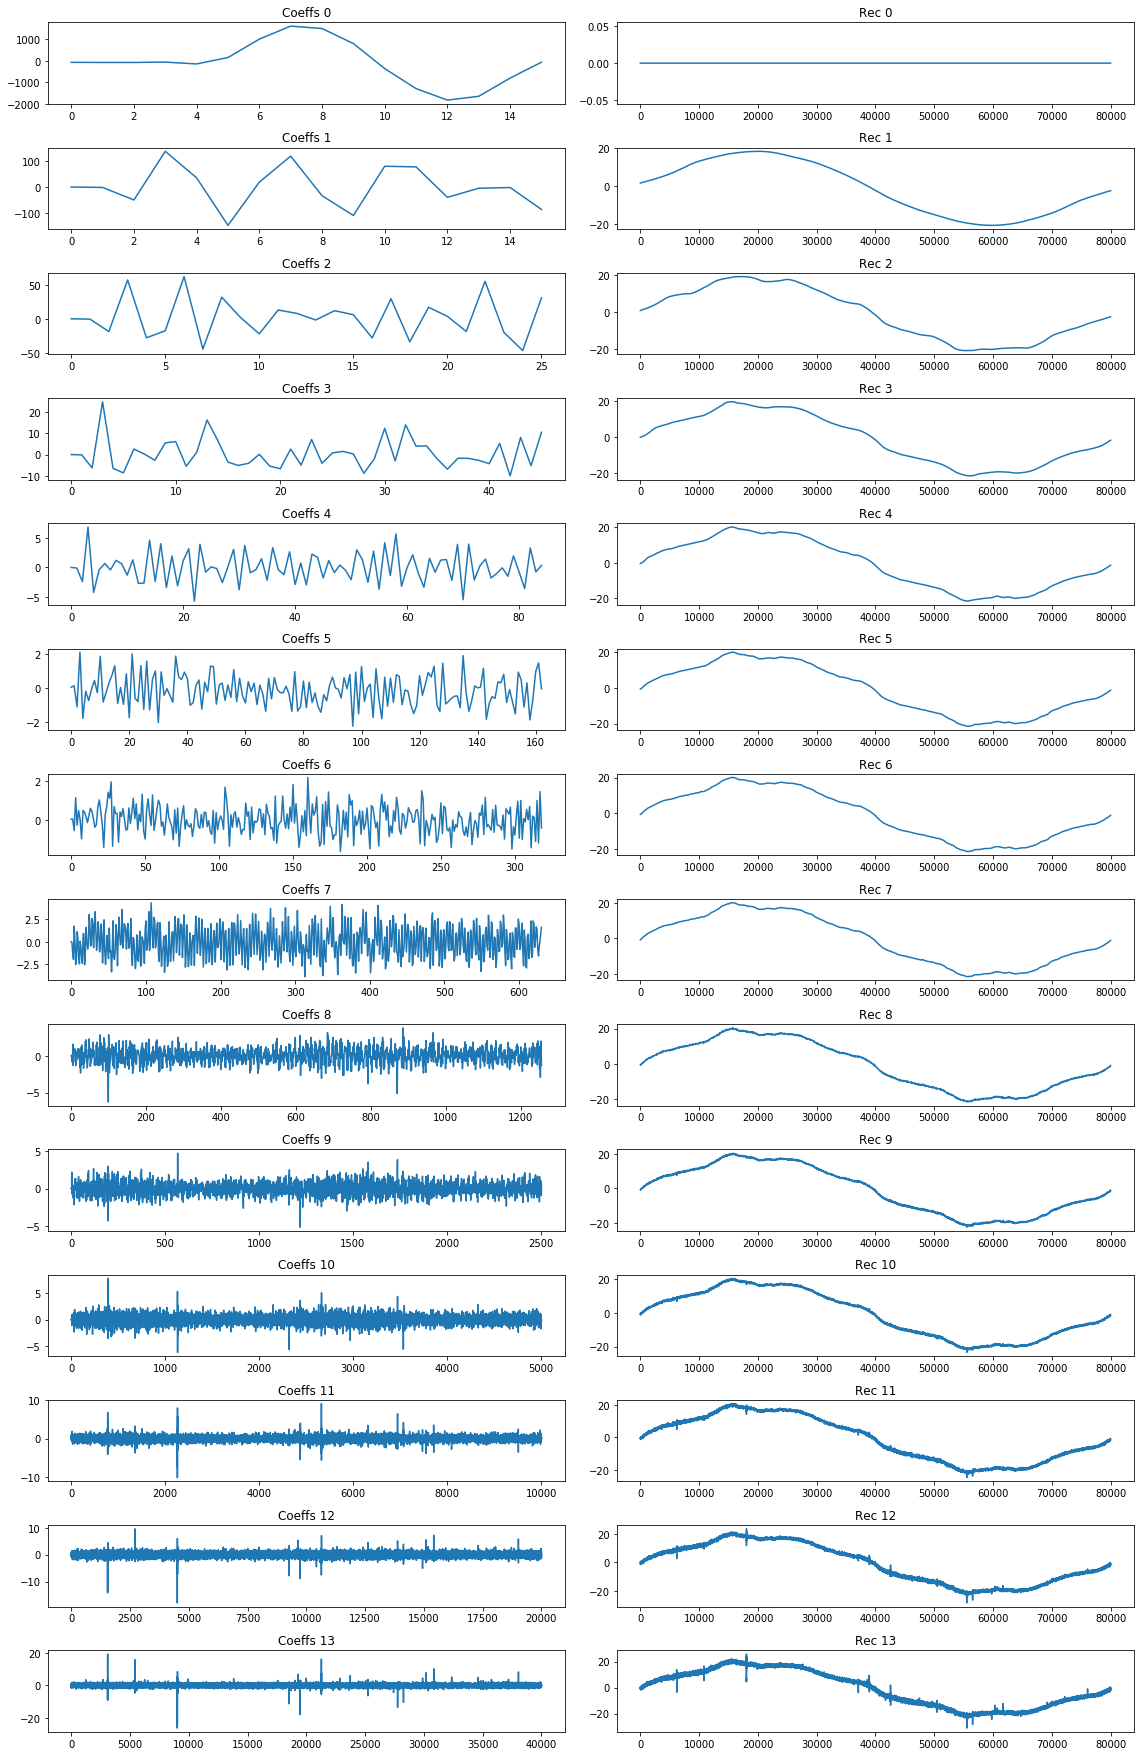

In [132]:
# Experiments zeroing out coeff levels

n_plots = len(coeffs)

fig, axs = plt.subplots(n_plots, 2, sharex=False, sharey=False, figsize=(8*2, n_plots * 1.75))

for i, coeff in enumerate(coeffs):
    cp_coeffs = coeffs.copy()
    for k in range(i, len(coeffs)):
        cp_coeffs[k] = coeffs[k] * 0
    temp_signal = pywt.waverec(cp_coeffs, 'db4')
    
    axs[i, 0].set_title(f'Coeffs {i}')
    axs[i, 1].set_title(f'Rec {i}')
    
    t = np.arange(0, coeff.size, 1)
    axs[i, 0].plot(t, coeff, alpha=1)
    
    z = np.arange(0, temp_signal.size, 1)
    axs[i, 1].plot(z, temp_signal, alpha=1)
    
fig.tight_layout()

# First real wavelet denoising

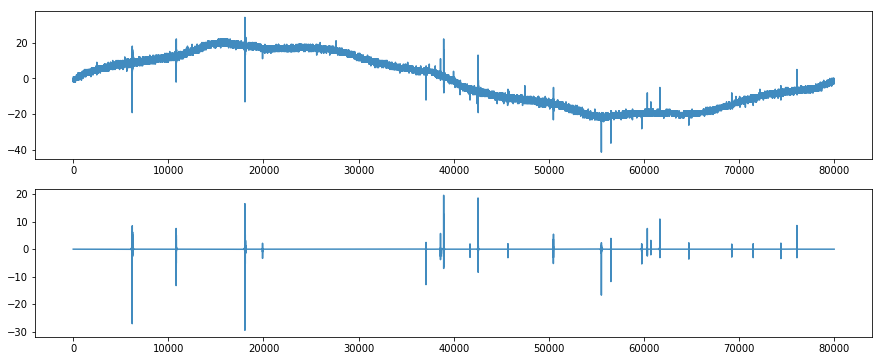

In [129]:
# Multi-level DWT
coeffs = pywt.wavedec(raw_signal, 'db7', level=None)

# Suppress sine wave (bigger scale D coeffs plus A coeffs)
for lvl in range(5):
    coeffs[lvl] = coeffs[lvl] * 0

# Threshold 'num_lvls_thresh' smaller scale levels

# Calculate thresholds
thresholds = [
    1/0.6745 * np.mean(np.abs(coeffs_ - np.mean(coeffs_))) * 
    np.sqrt(2 * np.log(coeffs_.size))
    for coeffs_ in coeffs
]

num_lvls_thresh = 8

# Apply hard thresholding per level
for lvl in np.arange(len(coeffs)-num_lvls_thresh, len(coeffs)):
    coeffs[lvl] = pywt.threshold(coeffs[lvl], value=thresholds[lvl], mode='hard')
    
# Reconstruction
rec_signal = pywt.waverec(coeffs, 'db7')

# Plot reconstruction
fig, axs = plt.subplots(2,1,figsize=(15,6))
t = np.arange(0, test_sample.shape[1], 1)
sns.lineplot(t, raw_signal, ax=axs[0], alpha=0.85)
sns.lineplot(t, rec_signal, ax=axs[1], alpha=0.85)

Okay so we've got DWT denoising basics down. This concludes our first EDA